<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Objective-&amp;-method" data-toc-modified-id="Objective-&amp;-method-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Objective &amp; method</a></span></li><li><span><a href="#Data-sources" data-toc-modified-id="Data-sources-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Data sources</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Maps" data-toc-modified-id="Maps-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Maps</a></span></li><li><span><a href="#Database-growth-in-bytes" data-toc-modified-id="Database-growth-in-bytes-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Database growth in bytes</a></span><ul class="toc-item"><li><span><a href="#Per-country-evolution-of-the-database-size-between-2014-and-2019" data-toc-modified-id="Per-country-evolution-of-the-database-size-between-2014-and-2019-0.5.1"><span class="toc-item-num">0.5.1&nbsp;&nbsp;</span>Per-country evolution of the database size between 2014 and 2019</a></span></li><li><span><a href="#Database-growth-rates-(2017-2019)" data-toc-modified-id="Database-growth-rates-(2017-2019)-0.5.2"><span class="toc-item-num">0.5.2&nbsp;&nbsp;</span>Database growth rates (2017-2019)</a></span></li></ul></li><li><span><a href="#Compared-to-population" data-toc-modified-id="Compared-to-population-0.6"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>Compared to population</a></span><ul class="toc-item"><li><span><a href="#Megabytes-per-million-people" data-toc-modified-id="Megabytes-per-million-people-0.6.1"><span class="toc-item-num">0.6.1&nbsp;&nbsp;</span>Megabytes per million people</a></span></li></ul></li><li><span><a href="#Compared-to-country-size" data-toc-modified-id="Compared-to-country-size-0.7"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>Compared to country size</a></span><ul class="toc-item"><li><span><a href="#Bytes-per-sq.-km" data-toc-modified-id="Bytes-per-sq.-km-0.7.1"><span class="toc-item-num">0.7.1&nbsp;&nbsp;</span>Bytes per sq. km</a></span></li><li><span><a href="#Map:-megabytes-per-million-people" data-toc-modified-id="Map:-megabytes-per-million-people-0.7.2"><span class="toc-item-num">0.7.2&nbsp;&nbsp;</span>Map: megabytes per million people</a></span></li><li><span><a href="#Map:-bytes-per-sq.-km" data-toc-modified-id="Map:-bytes-per-sq.-km-0.7.3"><span class="toc-item-num">0.7.3&nbsp;&nbsp;</span>Map: bytes per sq. km</a></span></li></ul></li></ul></li><li><span><a href="#Road-network" data-toc-modified-id="Road-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Road network</a></span><ul class="toc-item"><li><span><a href="#Importing-OSM-data-into-PostGIS" data-toc-modified-id="Importing-OSM-data-into-PostGIS-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing OSM data into PostGIS</a></span></li></ul></li></ul></div>

# OSM data availability in Sub-Saharan Africa
---

### Objective & method

The objective here is to gather information related to data availability in the OpenStreetMap database, more specifically in Sub-Saharan Africa. The problem is: there is no consensus on how to measure completeness in the OSM database (see the related [osm wiki page](https://wiki.openstreetmap.org/wiki/Completeness#Measuring_completeness)). 

In this notebook, we use the size of the database (in bytes) as a proxy of data availability. For each country and for several distinct years, we compare it to the country's surface and population. In the end, we obtain two metrics:

1. Megabytes of information per million people ;
2. Bytes of information per sq. kilometers.

This is a rough estimate of data completeness that does not take into account the complex relationships between urban density and econocmic/cultural/environmental factors. Also, it does not differentiate between the different types of objects in the database (road network, land use, points of interest, land cover, etc.).

### Data sources

The [geofabrik](http://download.geofabrik.de) website proposes geographic extracts (*i.e.* per region or country) of the OSM DB. Temporal snapshots (from 2014 to 2019) are also available. We use the size of these files (in bytes--as provided by the HTTP headers of the geofabrik server) as a proxy for data availability.

Population estimates are provided by the World Population Prospects and countries' geometries as an external GeoJSON file.

### Results

1. [Per-country evolution of the database size between 2014 and 2019](#Per-country-evolution-of-the-database-size-between-2014-and-2019)
2. [Per-country database growth rates between 2017 and 2019](#Database-growth-rates-(2017-2019))
3. [Megabytes per million people](#Database-growth-rates-(2017-2019))
4. [Bytes per sq. km](#Bytes-per-sq.-km)

### Maps

1. [Megabytes of information per million people](#Map%3A-megabytes-per-million-people)
2. [Bytes of information per sq. km](#Map%3A-bytes-per-sq.-km)

---

In [1]:
import os
import subprocess

import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from fiona import crs
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

%matplotlib inline

### Database growth in bytes

We scrape the web page `http://download.geofabrik.de/africa.html` to get a list of all the country names.

In [9]:
html_body = requests.get('http://download.geofabrik.de/africa.html').text
soup = BeautifulSoup(html_body, 'html.parser')

links = soup.find_all(name='a')
country_links = [a.attrs['href'] for a in links if 'latest.osm.pbf' in a.attrs['href']]

def _clean_link(href):
    """Clean URL to return only the country name."""
    href = href.replace('africa/', '')
    href = href.replace('-latest.osm.pbf', '')
    href = href.replace('.md5', '')
    return href

countries = list(map(_clean_link, country_links))
countries = [country for country in countries if country != 'africa']

print(', '.join(countries[:10]) + '...')

algeria, angola, benin, botswana, burkina-faso, burundi, cameroon, canary-islands, cape-verde, central-african-republic...


Geofabrik keeps an archive of data files for each country since 2014 (see [here](http://download.geofabrik.de/africa/congo-democratic-republic.html#) for DR Congo). We can estimate the quantity of information in the OSM database by reffering to the data file size (in bytes). To do so, we request the `Content-Length` HTTP header for each file.

In [10]:
def _build_url(continent, country, year):
    """Build URL to OSM data file."""
    year = str(year)[-2:]
    return 'http://download.geofabrik.de/{}/{}-{}0101.osm.pbf'.format(
        continent, country, year)

def osm_datasize(continent, country, year):
    """Get size in MB of the OSM data file for a given continent,
    country and year. The file size is fetched from the HTTP headers.
    """
    url = _build_url(continent, country, year)
    r = requests.head(url)
    if r.status_code == 200:
        size = int(r.headers['Content-Length'])
        return round(size * 10e-7, 1)
    return np.nan

In [11]:
dbsizes = pd.DataFrame(index=countries, columns=[2014, 2015, 2016, 2017, 2018, 2019])

for country in countries:
    for year in dbsizes.columns:
        dbsizes.at[(country, year)] = osm_datasize('africa', country, year)

#### Per-country evolution of the database size between 2014 and 2019

In [30]:
dbsizes.sort_values(by=2019, ascending=False)

,2014,2015,2016,2017,2018,2019
tanzania,8.6,10.8,37.3,87.3,180.3,345.3
south-africa-and-lesotho,57.1,82.7,122.4,171.3,211,230.1
nigeria,11,26.4,38.3,56.1,99.7,171.9
congo-democratic-republic,31.4,44.6,64.4,75.5,92.6,143.1
cameroon,23.8,53.1,78.3,111.9,117.1,132.7
zimbabwe,NaN,NaN,NaN,24.1,124,128.6
uganda,NaN,NaN,NaN,29.6,63.2,126
south-africa,NaN,NaN,NaN,94.1,107.7,125.2
mozambique,NaN,NaN,NaN,93.8,102.7,114.5
lesotho,NaN,NaN,43.8,79.5,105.7,107.3


#### Database growth rates (2017-2019)

In [29]:
growth_rates = (dbsizes[2019] - dbsizes[2017]) / dbsizes[2017]
growth_rates = growth_rates.astype(np.float32).round(2)
growth_rates.sort_values(ascending=False)

zimbabwe                                       4.34
uganda                                         3.26
tanzania                                       2.96
zambia                                         2.60
ghana                                          2.55
angola                                         2.34
seychelles                                     2.33
congo-brazzaville                              2.07
nigeria                                        2.06
eritrea                                        1.23
sudan                                          1.21
kenya                                          1.19
rwanda                                         1.18
mali                                           1.11
chad                                           1.07
somalia                                        0.98
malawi                                         0.90
congo-democratic-republic                      0.90
south-sudan                                    0.84
ivory-coast 

In [128]:
if not os.path.isdir('../data/output'):
    os.makedirs('../data/output')
dbsizes['GR_2017_2019'] = growth_rates
dbsizes.to_csv('../data/output/db_sizes.csv')

### Compared to population

We can compare DB sizes with population estimates to have a better idea of data coverage. Here we use population estimates from the [World Population Prospects](https://population.un.org/wpp/Download/Standard/Population/).

In [39]:
wpp = pd.read_csv('../data/input/WPP2015.csv', index_col='Country')

In [40]:
# Harmonize country names

COUNTRIES = {}

for country in dbsizes.index:
    # Try with uppercase
    country_formatted = country.title()
    if country_formatted in wpp.index:
        COUNTRIES[country] = country_formatted
        continue
    # Try without hyphens
    country_formatted = country_formatted.replace('-', ' ')
    if country_formatted in wpp.index:
        COUNTRIES[country] = country_formatted
        
COUNTRIES.update({
    'cape-verde': 'Cabo Verde',
    'comores': 'Comoros',
    'ivory-coast': "Côte d'Ivoire",
    'congo-brazzaville': 'Congo',
    'congo-democratic-republic': 'Democratic Republic of the Congo',
    'sao-tome-and-principe': 'Sao Tome and Principe',
    'tanzania': 'United Republic of Tanzania',
    'senegal-and-gambia': 'Senegal and Gambia'
})

In [95]:
# Drop nodata countries
dbsizes_pop = dbsizes.copy()
dbsizes_pop = dbsizes_pop.drop(index=[country for country in dbsizes.index if country not in COUNTRIES])
dbsizes_pop = dbsizes_pop.drop(columns=[2014, 2015, 2016])
dbsizes_pop.columns = ['DB_2017', 'DB_2018', 'DB_2019']
dbsizes_pop['POP_2015'] = None

In [96]:
for country, country_un in COUNTRIES.items():
    # Dealing with the "senegal and gambia" group
    if country == 'senegal-and-gambia':
        pop = wpp.at[('Senegal', 'Population')] + wpp.at[('Gambia', 'Population')]
    else:
        pop = wpp.at[(country_un, 'Population')]
    dbsizes_pop.at[(country), 'POP_2015'] = pop

# Update indexes
dbsizes_pop.index = [COUNTRIES[country] for country in dbsizes_pop.index]

In [97]:
dbsizes_pop['DB_POP_2017'] = dbsizes_pop.DB_2017 / (dbsizes_pop.POP_2015 * 10e-4)
dbsizes_pop['DB_POP_2018'] = dbsizes_pop.DB_2018 / (dbsizes_pop.POP_2015 * 10e-4)
dbsizes_pop['DB_POP_2019'] = dbsizes_pop.DB_2019 / (dbsizes_pop.POP_2015 * 10e-4)

#### Megabytes per million people

In [109]:
dbsizes_pop[['DB_POP_2017', 'DB_POP_2018', 'DB_POP_2019']].sort_values(by='DB_POP_2019', ascending=False)

,DB_POP_2017,DB_POP_2018,DB_POP_2019
Lesotho,36.5577,48.6056,49.3414
Seychelles,6.40055,8.53406,21.3352
Botswana,12.7196,15.2997,21.0484
Swaziland,16.3759,16.4517,16.6792
Cabo Verde,6.94297,9.38239,11.2589
Namibia,6.55518,7.99815,9.85339
Zimbabwe,1.5275,7.85932,8.15087
United Republic of Tanzania,1.62027,3.34633,6.40869
Zambia,1.7018,3.3477,6.124
Cameroon,4.90047,5.1282,5.81138


### Compared to country size

https://github.com/datasets/geo-countries/raw/master/data/countries.geojson

In [46]:
!wget -O ../data/input/countries.geojson -nc https://github.com/datasets/geo-countries/raw/master/data/countries.geojson

File ‘../data/input/countries.geojson’ already there; not retrieving.


In [102]:
countries_geom = gpd.read_file('../data/input/countries.geojson')
countries_geom.set_index(countries_geom.ADMIN, inplace=True)
countries_geom.drop(columns=['ADMIN', 'ISO_A3'], inplace=True)

In [103]:
dbsizes_geom = dbsizes_pop.copy()
dbsizes_geom['geometry'] = None

In [104]:
for country in dbsizes_pop.index:
    if country in countries_geom.index:
        dbsizes_geom.at[(country, 'geometry')] = countries_geom.at[(country, 'geometry')]
    # Edge cases
    elif country == 'Cabo Verde':
        dbsizes_geom.at[(country, 'geometry')] = countries_geom.at[('Cape Verde', 'geometry')]
    elif country == 'Congo':
        dbsizes_geom.at[(country, 'geometry')] = countries_geom.at[('Republic of Congo', 'geometry')]
    elif country == 'Côte d\'Ivoire':
        dbsizes_geom.at[(country, 'geometry')] = countries_geom.at[('Ivory Coast', 'geometry')]
    elif country == 'Guinea-Bissau':
        dbsizes_geom.at[(country, 'geometry')] = countries_geom.at[('Guinea Bissau', 'geometry')]
    elif country == 'Senegal and Gambia':
        senegal = countries_geom.at[('Senegal', 'geometry')]
        gambia = countries_geom.at[('Gambia', 'geometry')]
        dbsizes_geom.at[(country, 'geometry')] = senegal.union(gambia)

Switch to africa equal area projection for better surface accuracy.

In [105]:
africa_equal_area = crs.from_string("+proj=aea +lat_1=20 +lat_2=-23 +lat_0=0 +lon_0=25 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs")

In [106]:
dbsizes_geom = gpd.GeoDataFrame(dbsizes_geom)
dbsizes_geom.crs = crs.from_epsg(4326)
dbsizes_geom.to_crs(crs=africa_equal_area, inplace=True)
dbsizes_geom['surface'] = dbsizes_geom.geometry.apply(lambda x: x.area) * 1e-6
dbsizes_geom['DB_AREA_2017'] = dbsizes_geom.DB_2017 / dbsizes_geom.surface * 1e6
dbsizes_geom['DB_AREA_2018'] = dbsizes_geom.DB_2018 / dbsizes_geom.surface * 1e6
dbsizes_geom['DB_AREA_2019'] = dbsizes_geom.DB_2019 / dbsizes_geom.surface * 1e6

#### Bytes per sq. km

In [113]:
dbsizes_geom[['DB_AREA_2017', 'DB_AREA_2018', 'DB_AREA_2019']].sort_values(by='DB_AREA_2019', ascending=False)

,DB_AREA_2017,DB_AREA_2018,DB_AREA_2019
Seychelles,1377.21,1836.28,4590.69
Lesotho,2640.63,3510.88,3564.02
Mauritius,1389.97,1936.03,2432.45
Cabo Verde,952.835,1287.61,1545.14
Swaziland,1262.28,1268.12,1285.65
Comoros,837.207,1076.41,1255.81
Malawi,305.701,442.219,579.575
Sao Tome and Principe,385.67,482.087,578.505
Rwanda,245.01,478.165,533.49
Uganda,122.388,261.315,520.977


Write results to disk 

In [140]:
if not os.path.isdir('../data/output'):
    os.makedirs('../data/output')
results = dbsizes_geom.drop(columns=['POP_2015', 'surface'])
results['GR_2017_2019'] = (results['DB_2019'] - results['DB_2017']) / results['DB_2017']
results.drop(columns=['geometry']).astype(np.float32).round(2).to_csv('../data/output/osmdb_densities.csv')
results.geometry.to_file('../data/output/countries.geojson', driver='GeoJSON')

#### Map: megabytes per million people

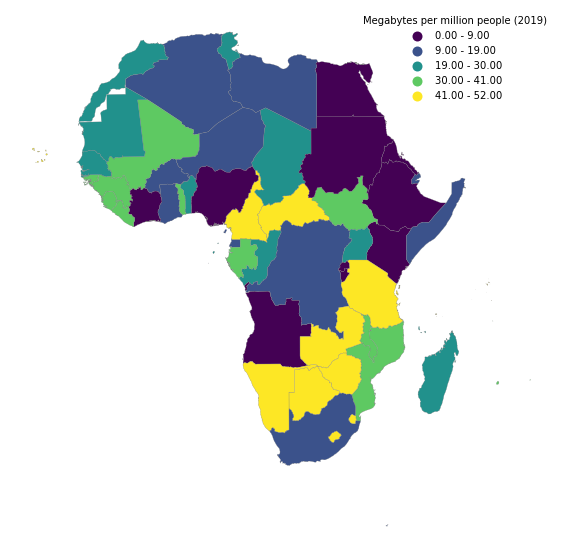

In [124]:
results.plot(
    column='DB_POP_2019',
    cmap='viridis',
    edgecolor='grey',
    linewidth=0.25,
    scheme='Fisher_Jenks',
    legend=True,
    legend_kwds={'title': 'Megabytes per million people (2019)', 'frameon': False},
    figsize=(15, 10)
)
plt.axis(False)
plt.savefig('../data/output/megabytes_per_million_people.pdf', dpi=300);

#### Map: bytes per sq. km

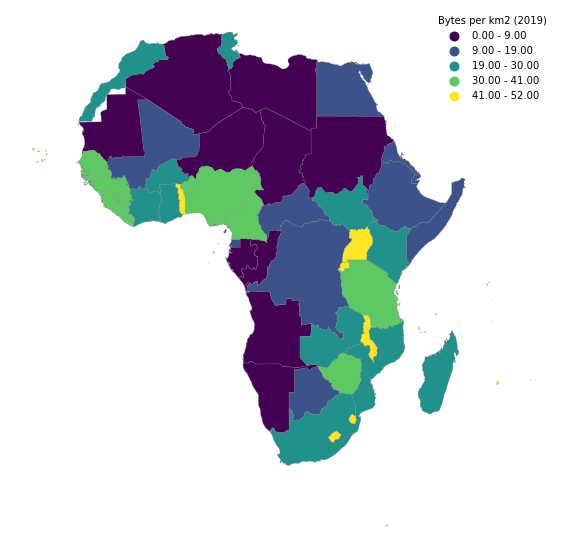

In [123]:
dbsizes_geom.plot(
    column='DB_AREA_2019',
    cmap='viridis',
    edgecolor='grey',
    linewidth=0.25,
    scheme='Fisher_Jenks',
    legend=True,
    legend_kwds={'title': 'Bytes per km2 (2019)', 'frameon': False},
    figsize=(15, 10)
)
plt.axis(False)
plt.savefig('../data/output/bytes_per_sq_km.pdf', dpi=300);

## Road network

In [6]:
from datetime import datetime

In [34]:
class RoadLengthHandler(osmium.SimpleHandler):
    
    def __init__(self, date):
        super(RoadLengthHandler, self).__init__()
        self.length = {}
        self.date = date
    
    def way(self, w):
        if w.timestamp < self.date and 'highway' in w.tags and not w.deleted:
            road_type = w.tags['highway']
            if road_type not in self.length:
                self.length[road_type] = 0
            try:
                self.length[road_type] += osmium.geom.haversine_distance(w.nodes)
            except osmium.InvalidLocationError:
                pass

def roads_length(osm_file, date):
    handler = RoadLengthHandler(date)
    handler.apply_file(osm_file, locations=True)
    return handler.length

In [35]:
import pytz

In [36]:
osm_file = 'data/togo-internal.osh.pbf'
date = datetime(2014, 1, 1, tzinfo=pytz.UTC)
length = roads_length(osm_file, date)
length = pd.Series(index=length.keys(), data=list(length.values()))
length /= 1000
print(length.sum())

224732.78225045255


In [37]:
length.sort_values(ascending=False)

unclassified                         53237.402539
primary                              42711.614250
tertiary                             35551.727101
secondary                            27891.912202
residential                          26587.768658
track                                14059.756449
path                                 12402.094178
trunk                                 6755.573642
road                                  4080.720152
service                                793.493770
footway                                267.586094
cycleway                               109.963565
construction                            67.785564
tertiary_link                           62.468593
pedestrian                              28.814274
living_street                           25.532651
primary_link                            21.691687
trunk_link                              13.424526
yes                                      9.604539
secondary_link                           9.464339


### Importing OSM data into PostGIS

To analyze OSM road networks, OSM data must be downloaded and imported into a PostGIS database. We download 6 different snapshots (~8GB) from geofabrik in order to conduct a multi-temporal analysis.